# Setup

---



Install python packages.

In [0]:
!pip install scanpy
!pip install python-igraph
!pip install louvain
!pip install seaborn
!pip install scipy
!pip install sklearn
!pip install rpy2==3.2.2
!pip install anndata2ri
!pip install diffxpy
!pip install bbknn
!pip install loompy

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import csv
import scanpy as sc
import seaborn as sb
import scipy as sp
import matplotlib.pyplot as plt
import diffxpy.api as de
import bbknn as bk
from rpy2.robjects import pandas2ri
import anndata2ri
from rpy2.robjects import r
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython
import base64
import json
import os
import zlib
#from optparse import OptionParser
import loompy as lp

In [0]:
%%R
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("S4Vectors")
BiocManager::install("SingleCellExperiment")
BiocManager::install('RColorBrewer')
BiocManager::install('slingshot')
BiocManager::install('scater')

In [6]:
%%R
library(RColorBrewer)
library(slingshot)
library(scater)

R[write to console]: Loading required package: princurve

R[write to console]: Loading required package: SingleCellExperiment

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
 

In [7]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = '/content/drive/My Drive/IntegratedProject/Data/write/facs_Bcell.h5ad'  # the file that will store the analysis results

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.4 scipy==1.3.3 pandas==0.25.3 scikit-learn==0.21.3 statsmodels==0.10.2 python-igraph==0.7.1 louvain==0.6.1


In [0]:
sc.settings.set_figure_params(dpi=80)

# Data selection

---



In [0]:
meta = pd.read_csv("/content/drive/My Drive/IntegratedProject/Data/Metadata/TM_facs_metadata.csv") #need to switch to metadata for entire set of data
adata = sc.read_csv(
    '/content/drive/My Drive/IntegratedProject/Data/TM_facs_mat_Bcell.csv') #file needs to be switched to one containing all the data

In [0]:
adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

Adding new columns to adata.obs to keep track of plate, id of the mouse, sex of the mouse, tissue, subtiusse and the cell annotation from the original paper.

Then each of these columns is filled with the respective data from the metadata for each cell.

In [0]:
adata.obs = adata.obs.assign(plate='')
adata.obs = adata.obs.assign(mouse_id='')
adata.obs = adata.obs.assign(mouse_sex='')
adata.obs = adata.obs.assign(tissue='')
adata.obs = adata.obs.assign(subtissue='')
adata.obs = adata.obs.assign(ref_annotation='')

for i in range(len(meta)):
  cellid = meta.iloc[i,0]
  if cellid in adata.obs_names:
    if meta.iloc[i,7] == 'NA':
      cells_na.append(cellid)
    adata.obs.loc[cellid, 'plate'] = meta.iloc[i,1]
    adata.obs.loc[cellid, 'mouse_id'] = meta.iloc[i,2]
    adata.obs.loc[cellid, 'mouse_sex'] = meta.iloc[i,6]
    adata.obs.loc[cellid, 'tissue'] = meta.iloc[i,3]
    adata.obs.loc[cellid, 'subtissue'] = meta.iloc[i,4]
    adata.obs.loc[cellid, 'ref_annotation'] = meta.iloc[i,7]

In [12]:
adata

AnnData object with n_obs × n_vars = 3888 × 23433 
    obs: 'plate', 'mouse_id', 'mouse_sex', 'tissue', 'subtissue', 'ref_annotation'

# Preprocessing

First we remove the spike in ERCC genes.

In [13]:
adata = adata[:,adata.var_names.str.startswith('ERCC')!=True]
adata

View of AnnData object with n_obs × n_vars = 3888 × 23341 
    obs: 'plate', 'mouse_id', 'mouse_sex', 'tissue', 'subtissue', 'ref_annotation'

Each cell and gene are individually shown to see how many genes are expressed in each cell as well as how many cells each gene is expressed in.

In [14]:
sc.pp.calculate_qc_metrics(adata)

(                         n_genes_by_counts  ...  pct_counts_in_top_500_genes
 A1.B000971.3_39_F.1.1                 1800  ...                    79.948883
 A1.B001750.3_38_F.1.1                 1357  ...                    92.381691
 A1.MAA000508.3_9_M.1.1                1803  ...                    88.108569
 A1.MAA000559.3_8_M.1.1                1753  ...                    86.956464
 A1.MAA000652.3_10_M.1.1               1364  ...                    91.714589
 ...                                    ...  ...                          ...
 P9.MAA000877.3_11_M.1.1               2376  ...                    82.240139
 P9.MAA000914.3_9_M.1.1                1330  ...                    93.646008
 P9.MAA001883.3_39_F.1.1               1867  ...                    81.305749
 P9.MAA001884.3_38_F.1.1               1527  ...                    91.024431
 P9.MAA001889.3_38_F.1.1               1622  ...                    95.049253
 
 [3888 rows x 8 columns],
                    n_cells_by_count

Basic filtering on our data so that genes that are detected in less than 3 cells are removed as well as cells that have less than 500 genes expressed and cells that have less than 50,000 counts.

In [15]:
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_cells(adata, min_counts=50000)
sc.pp.filter_genes(adata, min_cells=3)
adata

Trying to set attribute `.obs` of view, making a copy.


filtered out 5924 genes that are detectedin less than 3 cells


AnnData object with n_obs × n_vars = 3888 × 17417 
    obs: 'plate', 'mouse_id', 'mouse_sex', 'tissue', 'subtissue', 'ref_annotation', 'n_genes', 'n_counts'
    var: 'n_cells'

Computes for each gene the fraction of counts assigned to that gene within a cell and shows a boxplot with the top 20 genes with the highest mean fraction across all cells.

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


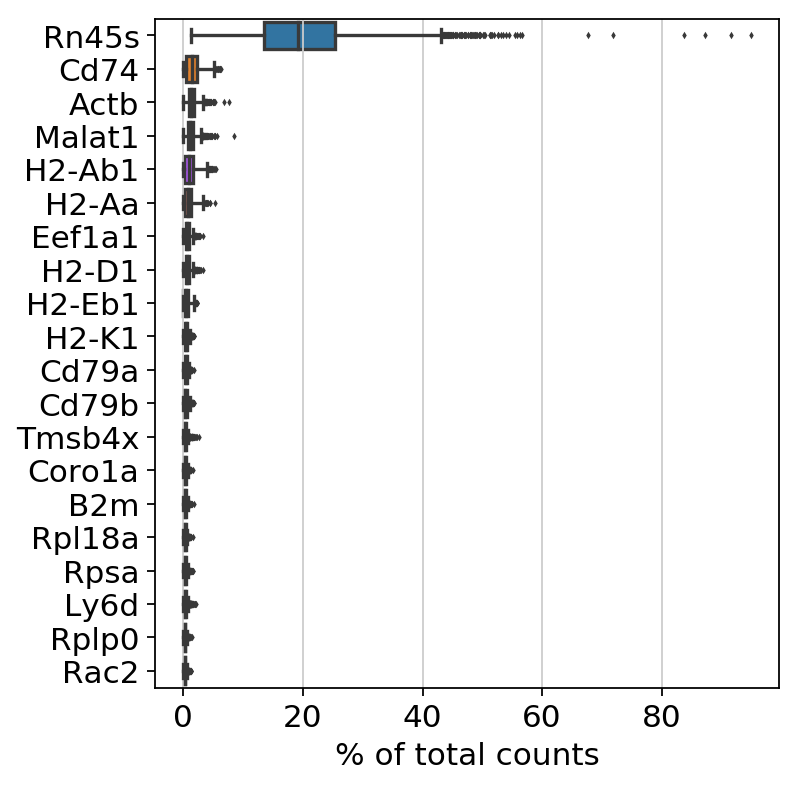

In [16]:
sc.pl.highest_expr_genes(adata, n_top=20)

Collect a list of the mitochondrial genes in our data set and create a new observation column in the adata.obs percent_mito which is the percentage of mitochondrial gene counts vs all total gene counts.

Having information about mitochonrdrial genes is important because high proportions are indicative of poor-quality cells since this could indicate a cell with tears in the cell membrane and since mitochondria are larger than individual transcript molecules they are less likely to escape through the tears.

The n_counts observation is also updated to account for the filtering done previously.

In [0]:
mito_genes = adata.var_names.str.startswith('mt-','tssr')

adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)

adata.obs['n_counts'] = adata.X.sum(axis=1)

Create a violin plot for the number of genes and counts for each cell to provide more information about our cells for future filtering.

... storing 'plate' as categorical
... storing 'mouse_id' as categorical
... storing 'mouse_sex' as categorical
... storing 'tissue' as categorical
... storing 'subtissue' as categorical
... storing 'ref_annotation' as categorical


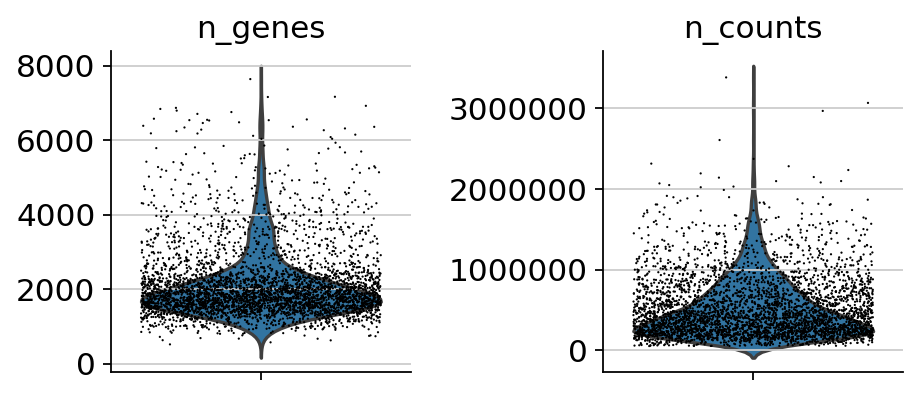

In [18]:
sc.pl.violin(adata, ['n_genes', 'n_counts'],
             jitter=0.4, multi_panel=True)


Create two scatter plots, the first comparing the number of counts and percentage of mitochonridal genes and the second comparing number of counts and number of genes for our dataset.

The first scatter plot is commented out because we do not actually have any mitochondrial genes in our data.



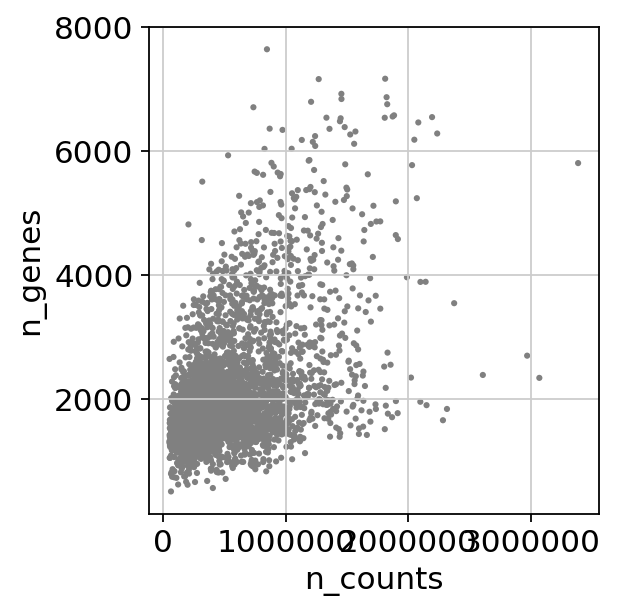

In [19]:
#sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

Check our data to see how the number of counts and number of genes are distributed across our cells.

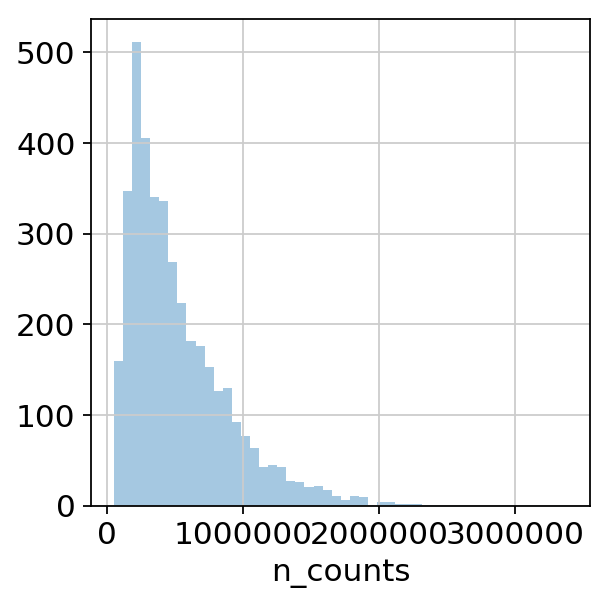

In [20]:
sb.distplot(adata.obs['n_counts'], kde=False)

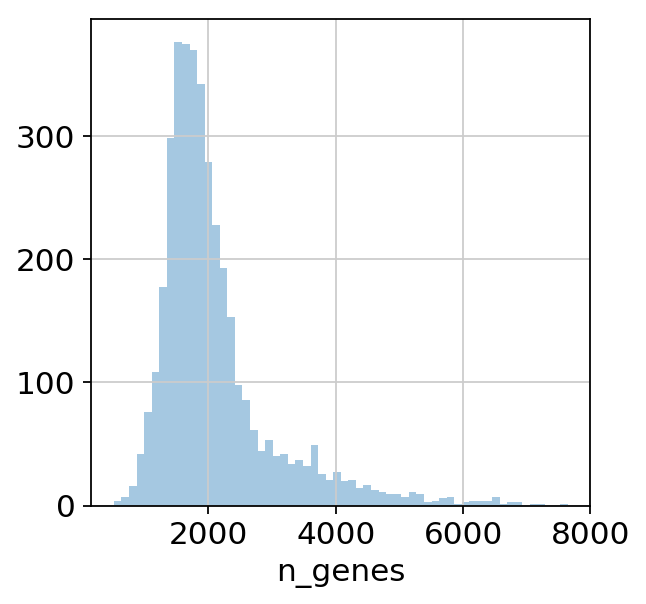

In [21]:
sb.distplot(adata.obs['n_genes'], kde=False, bins=60)

Based on the previous plots we filter our data again to remove cells with too low or too high number of genes and cells with too low and too high number of counts. If there were mitochondrial genes present then cells with too high a percentage of those genes would be removed also.

These cells are filtered out to remove outliers from our data.

In [0]:
adata = adata[adata.obs['n_genes'] > 500, :]
adata = adata[adata.obs['n_genes'] < 6000, :]
adata = adata[adata.obs['n_counts'] > 50000, :]
adata = adata[adata.obs['n_counts'] < 2000000, :]
#adata = adata[adata.obs['percent_mito'] < 0.05, :]

Make new object adata.raw which is adata in its current state the raw (un-normalized, uncorrected and unscaled) form of our data.

In [0]:
adata.raw = adata

Total-count normalize the data matrix to 10,000 reads per cell, so that counts become comparable among cells.

In [24]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


Logarithmize the data.

In [0]:
sc.pp.log1p(adata)

Regress out effects of total counts per cell.

In [26]:
sc.pp.regress_out(adata, ['n_counts'])

regressing out ['n_counts']
    finished (0:01:14)


Scale each gene to unit variance. Clip values exceeding standard deviation 10. 

In [0]:
sc.pp.scale(adata, max_value=10)

In [0]:
adata.write(results_file)

# Differential Expression

Creating function to make pairwise volcano plots between cell sub-populations.

In [0]:
def pairwiseDE(test_by,test_groups,subset_by=None,subset=None):
  if subset_by:
    adata_sub = adata[adata.obs[subset_by].str.contains(subset)]
  else:
    adata_sub = adata

  i=0
  while i < len(test_groups)-1:
    for j in range(i+1,len(test_groups)):
      pair = [test_groups[i], test_groups[j]]
      print ("Differential expression: %s vs %s" %(pair[0],pair[1]))
      regex = '|'.join(pair)
      adata_test = adata_sub[adata_sub.obs[test_by].str.contains(regex)]
      grouping = adata_test.obs[test_by].tolist()
      test = de.test.two_sample(adata_test.raw.X, grouping, gene_names=adata_test.var_names.to_list())
      test.plot_volcano()
      table = test.summary().sort_values('pval', axis = 0, ascending=True)
      print(table.iloc[:20,:])
    i+=1

Differential expression of B cells between Spleen, Marrow, Lung, Limb Muscle, and Liver tissues.

Differential expression: Marrow vs Spleen


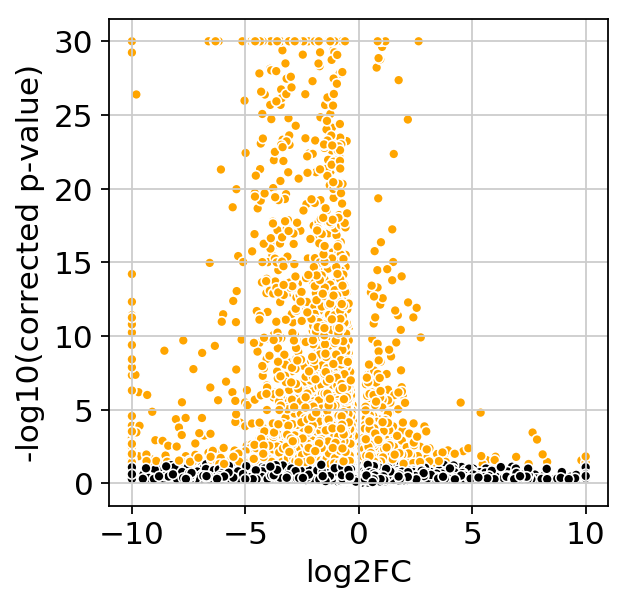

           gene           pval  ...  zero_mean  zero_variance
16543    Vpreb3  3.951214e-122  ...      False          False
8431       Jund   1.406257e-96  ...      False          False
15346      Tifa   2.319100e-90  ...      False          False
8429        Jun   6.292312e-81  ...      False          False
11201  Pafah1b3   4.128279e-77  ...      False          False
14565      Sox4   1.066086e-75  ...      False          False
3725    Chchd10   5.778165e-73  ...      False          False
3427      Cd24a   5.346874e-69  ...      False          False
1724     Akap12   2.553623e-68  ...      False          False
4001        Cnp   1.216639e-66  ...      False          False
14295   Smarca4   7.084788e-65  ...      False          False
8179       Il7r   8.831679e-65  ...      False          False
15180      Tcf3   2.937627e-63  ...      False          False
3622      Cecr2   1.623983e-61  ...      False          False
2187      Arl5c   5.727828e-59  ...      False          False
16793   

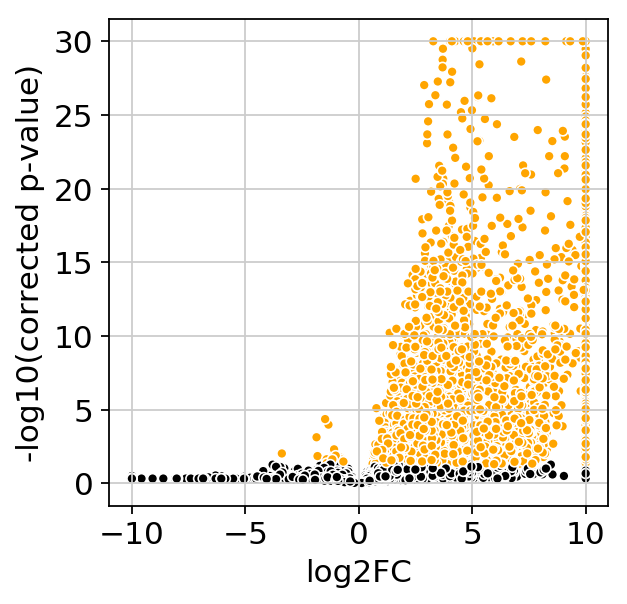

                gene          pval  ...  zero_mean  zero_variance
10238            Myb  4.611333e-63  ...      False          False
16793          Xrcc6  1.298009e-62  ...      False          False
2724           Bcl7a  6.954474e-61  ...      False          False
7762        Hist1h4m  1.889997e-58  ...      False          False
8179            Il7r  9.181581e-58  ...      False          False
3622           Cecr2  2.605982e-57  ...      False          False
10275           Myl4  1.066811e-52  ...      False          False
4173           Cplx2  2.976520e-47  ...      False          False
3514        Cdc42ep3  9.109334e-47  ...      False          False
9012           Lmnb1  1.483109e-46  ...      False          False
597    2810417H13Rik  5.437800e-42  ...      False          False
2780           Birc5  6.023473e-41  ...      False          False
9841           Mki67  6.291161e-41  ...      False          False
3347           Ccna2  4.935976e-40  ...      False          False
15780     

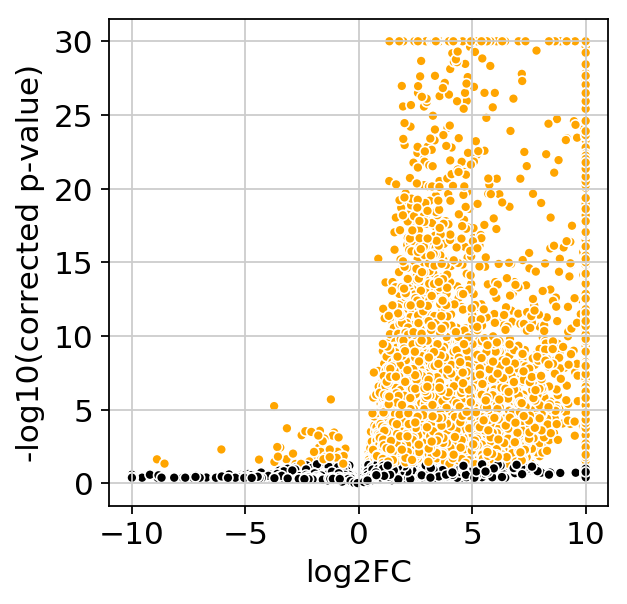

           gene           pval  ...  zero_mean  zero_variance
16543    Vpreb3  3.333365e-137  ...      False          False
3725    Chchd10   3.949475e-92  ...      False          False
5772    Fam129c   4.689747e-87  ...      False          False
14565      Sox4   1.505198e-72  ...      False          False
2365     Atp1b1   1.924715e-72  ...      False          False
5892     Fam53b   9.666767e-70  ...      False          False
9075       Lrmp   3.258120e-67  ...      False          False
5434      Elof1   7.391153e-67  ...      False          False
8179       Il7r   1.055199e-66  ...      False          False
11201  Pafah1b3   4.211103e-63  ...      False          False
3622      Cecr2   5.443424e-63  ...      False          False
10238       Myb   7.478706e-63  ...      False          False
11549      Pgls   1.744593e-62  ...      False          False
13986    Slc1a5   1.481347e-60  ...      False          False
8935     Lgals9   8.664479e-60  ...      False          False
3353    

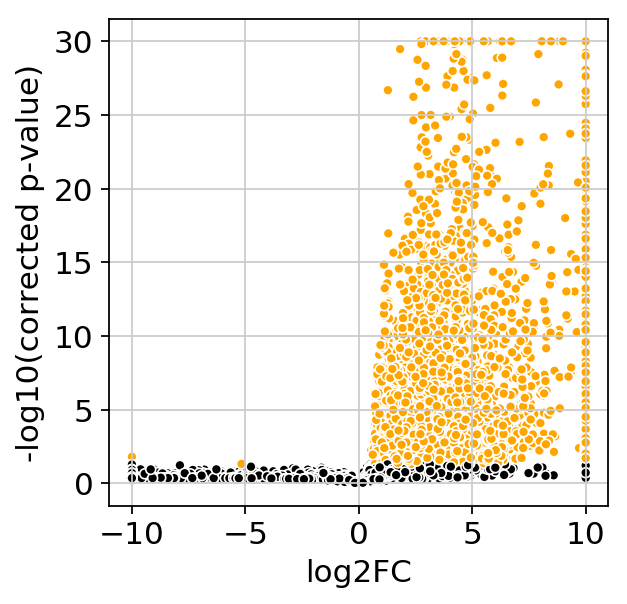

          gene          pval  ...  zero_mean  zero_variance
5892    Fam53b  7.475531e-73  ...      False          False
3622     Cecr2  3.901956e-72  ...      False          False
10275     Myl4  3.629962e-64  ...      False          False
10238      Myb  4.363440e-63  ...      False          False
5772   Fam129c  4.174393e-60  ...      False          False
16543   Vpreb3  9.834701e-60  ...      False          False
1724    Akap12  4.444646e-56  ...      False          False
14295  Smarca4  2.476264e-54  ...      False          False
2724     Bcl7a  1.267648e-51  ...      False          False
16793    Xrcc6  2.338207e-51  ...      False          False
5220      E2f2  2.461886e-49  ...      False          False
9017      Lmo4  3.574871e-49  ...      False          False
16424    Usp39  7.824976e-46  ...      False          False
4173     Cplx2  8.251595e-46  ...      False          False
10701   Nmral1  3.493222e-45  ...      False          False
2187     Arl5c  2.356691e-44  ...      F

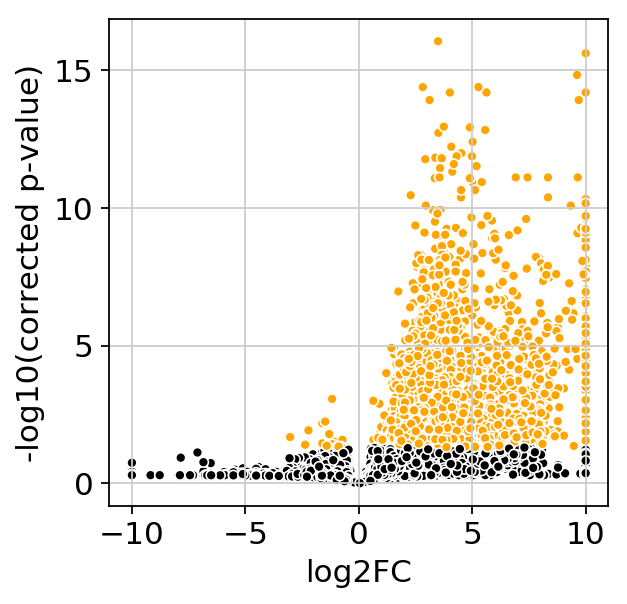

           gene          pval  ...  zero_mean  zero_variance
4647       Dars  5.504451e-21  ...      False          False
7762   Hist1h4m  2.994466e-20  ...      False          False
1809     Alkbh7  2.744100e-19  ...      False          False
16922    Zcchc8  1.075095e-18  ...      False          False
3558      Cdk13  1.259653e-18  ...      False          False
7663       Hes1  2.479438e-18  ...      False          False
1666     Agpat3  2.869660e-18  ...      False          False
7763   Hist1h4n  3.170701e-18  ...      False          False
11950    Polr2b  6.712869e-18  ...      False          False
4202        Cr2  7.482425e-18  ...      False          False
17412       Zyx  7.524605e-17  ...      False          False
3408      Cd1d1  8.756450e-17  ...      False          False
4121       Coq5  1.174878e-16  ...      False          False
11154     Oxa1l  1.606016e-16  ...      False          False
10733      Nop2  3.654136e-16  ...      False          False
6569     Gigyf2  5.85445

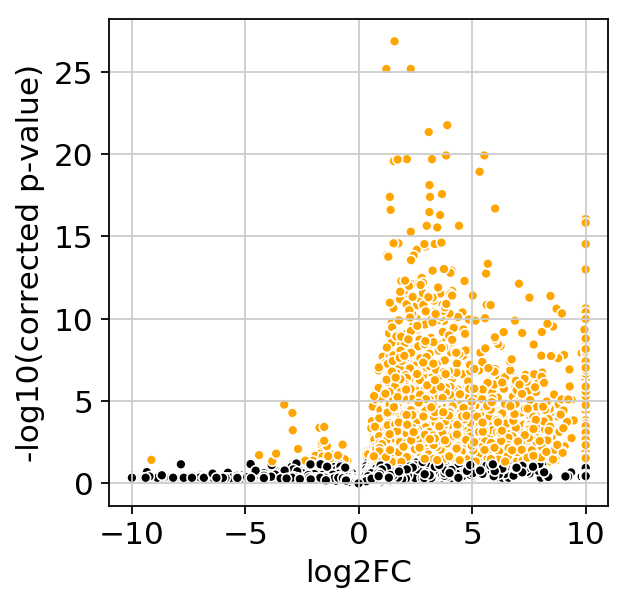

           gene          pval  ...  zero_mean  zero_variance
2136    Arhgdib  8.324650e-32  ...      False          False
12463     Ptpn6  9.358733e-30  ...      False          False
13042     Rn45s  1.198377e-29  ...      False          False
16014      Tsix  4.135419e-26  ...      False          False
15836  Traf3ip3  1.357658e-25  ...      False          False
3170    Cbfa2t3  4.744047e-24  ...      False          False
9871      Mllt6  5.005596e-24  ...      False          False
3091       Capg  9.838285e-24  ...      False          False
14168   Slc44a2  1.084688e-23  ...      False          False
9208       Ly6d  1.259722e-23  ...      False          False
3476      Cd79b  1.721163e-23  ...      False          False
7935      Hsh2d  8.349372e-23  ...      False          False
15905   Trim34a  5.889061e-22  ...      False          False
15525   Tmem173  2.206105e-21  ...      False          False
4126     Coro1a  3.657964e-21  ...      False          False
6575     Gimap7  3.77935

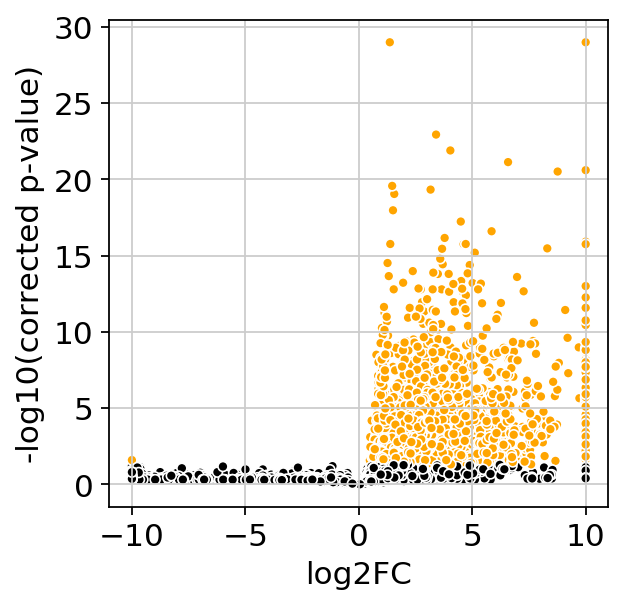

                gene          pval  ...  zero_mean  zero_variance
13217         Rpl37a  1.031409e-33  ...      False          False
16014           Tsix  1.229968e-33  ...      False          False
16823         Yme1l1  2.070257e-27  ...      False          False
8299            Irf9  3.036000e-26  ...      False          False
3379            Ccr6  2.199957e-25  ...      False          False
13207     Rpl31-ps12  8.923007e-25  ...      False          False
16424          Usp39  1.278978e-24  ...      False          False
13273          Rps29  1.276274e-23  ...      False          False
12782          Rbm15  2.519651e-23  ...      False          False
9809          Mir682  5.388862e-23  ...      False          False
13267          Rps25  6.982744e-22  ...      False          False
15399           Tlr1  4.170058e-21  ...      False          False
15955          Trnt1  1.953772e-20  ...      False          False
9926            Mob4  5.776373e-20  ...      False          False
321    181

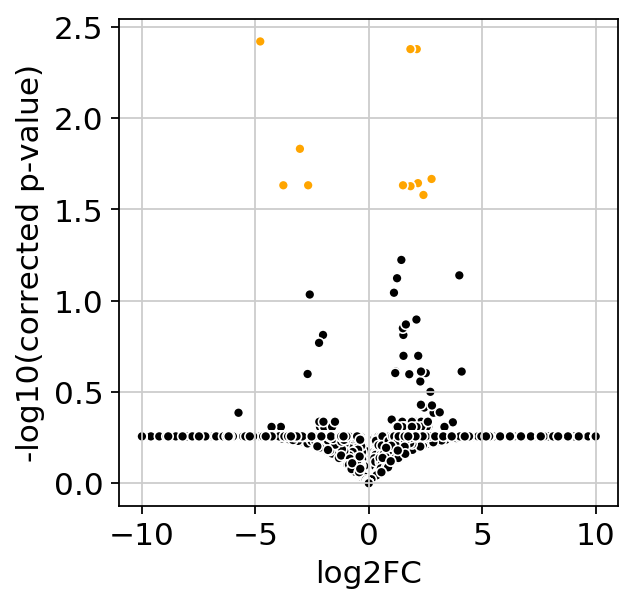

          gene          pval      qval  ...         mean  zero_mean  zero_variance
4226      Crem  2.898606e-07  0.003805  ...    92.795275      False          False
12639     Rac2  8.838697e-07  0.004191  ...   904.417338      False          False
3476     Cd79b  9.578502e-07  0.004191  ...  1549.102375      False          False
8993     Litaf  4.489831e-06  0.014735  ...   164.346461      False          False
14735    Srsf5  8.208754e-06  0.021551  ...   151.818900      False          False
9208      Ly6d  1.038315e-05  0.022717  ...   997.559044      False          False
15760     Tob2  1.401367e-05  0.023338  ...    28.251969      False          False
2136   Arhgdib  1.434273e-05  0.023338  ...   902.850365      False          False
16561   Vps37b  1.714811e-05  0.023338  ...    83.614173      False          False
15999  Tsc22d3  1.777887e-05  0.023338  ...   678.850381      False          False
12469  Ptprcap  1.978257e-05  0.023608  ...   456.181107      False          False
9179

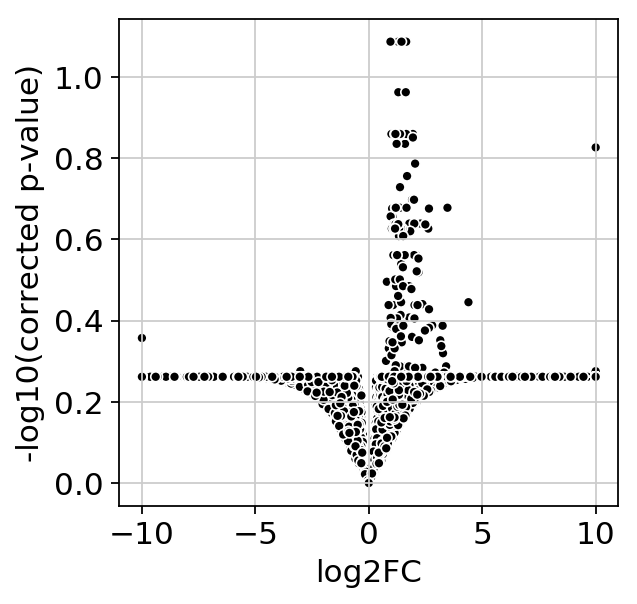

          gene      pval      qval  ...         mean  zero_mean  zero_variance
12639     Rac2  0.000006  0.081841  ...  1095.484555      False          False
9290    Malat1  0.000028  0.081841  ...  4809.556731      False          False
13217   Rpl37a  0.000033  0.081841  ...   231.917525      False          False
3476     Cd79b  0.000036  0.081841  ...  1975.154632      False          False
15676   Tmsb4x  0.000036  0.081841  ...  1824.577337      False          False
7505     H2-D1  0.000037  0.081841  ...  3461.422567      False          False
13204     Rpl3  0.000063  0.109000  ...   702.412350      False          False
3475     Cd79a  0.000066  0.109000  ...  2067.505101      False          False
12469  Ptprcap  0.000098  0.138137  ...   543.927839      False          False
9208      Ly6d  0.000131  0.138137  ...  1264.257719      False          False
13259    Rps19  0.000132  0.138137  ...   642.288648      False          False
15999  Tsc22d3  0.000144  0.138137  ...   814.103071

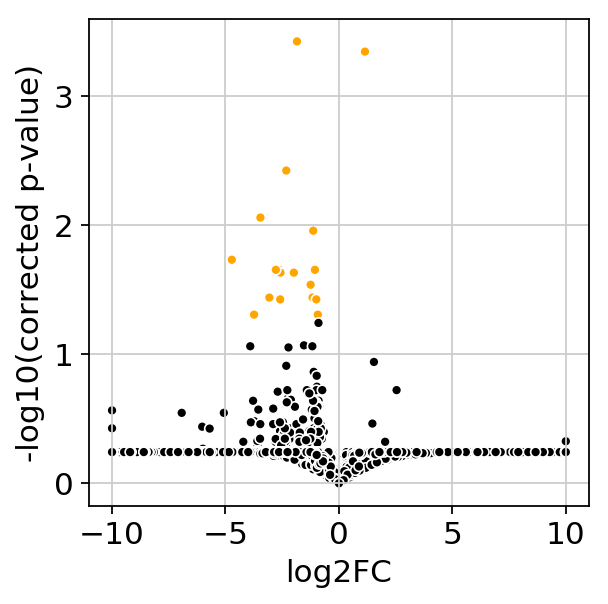

          gene          pval      qval  ...          mean  zero_mean  zero_variance
14732    Srsf2  2.813045e-08  0.000377  ...    276.267852      False          False
13042    Rn45s  6.750563e-08  0.000452  ...  57530.501779      False          False
8430      Junb  8.449110e-07  0.003774  ...    649.419641      False          False
4226      Crem  2.607135e-06  0.008735  ...    107.660713      False          False
7502     H2-Aa  4.119993e-06  0.011043  ...   4860.937476      False          False
16561   Vps37b  8.296771e-06  0.018532  ...     91.580356      False          False
5735   Fam107b  1.246415e-05  0.022181  ...    214.008935      False          False
13273    Rps29  1.354093e-05  0.022181  ...     98.142857      False          False
13462    Satb1  1.489534e-05  0.022181  ...    138.919639      False          False
8025      Ier2  1.766058e-05  0.023328  ...    213.830364      False          False
8993     Litaf  1.914703e-05  0.023328  ...    186.482147      False        

In [30]:
test_by = 'tissue'
test_groups = ['Marrow', 'Spleen', 'Lung', 'Limb_Muscle', 'Liver']
pairwiseDE(test_by, test_groups)

# Dimensionality Reduction, Data Correction, Clustering and Cell Annotation

Identify the highly-variable genes in our dataset, genes with expression that is very different between cells. These our the target genes to look at as they are different between cells and can be used to identify different cell types.

The function also adds new columns to adata.var which indicates for each gene whether it is highly variable and what its mean expression, dispersion and normalized dispersion are.

In [31]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=10, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Create two scatter plots showing dispersion of genes (normalized and non normalized) versus mean expression of genes where the highly variable genes are separately labeled. 

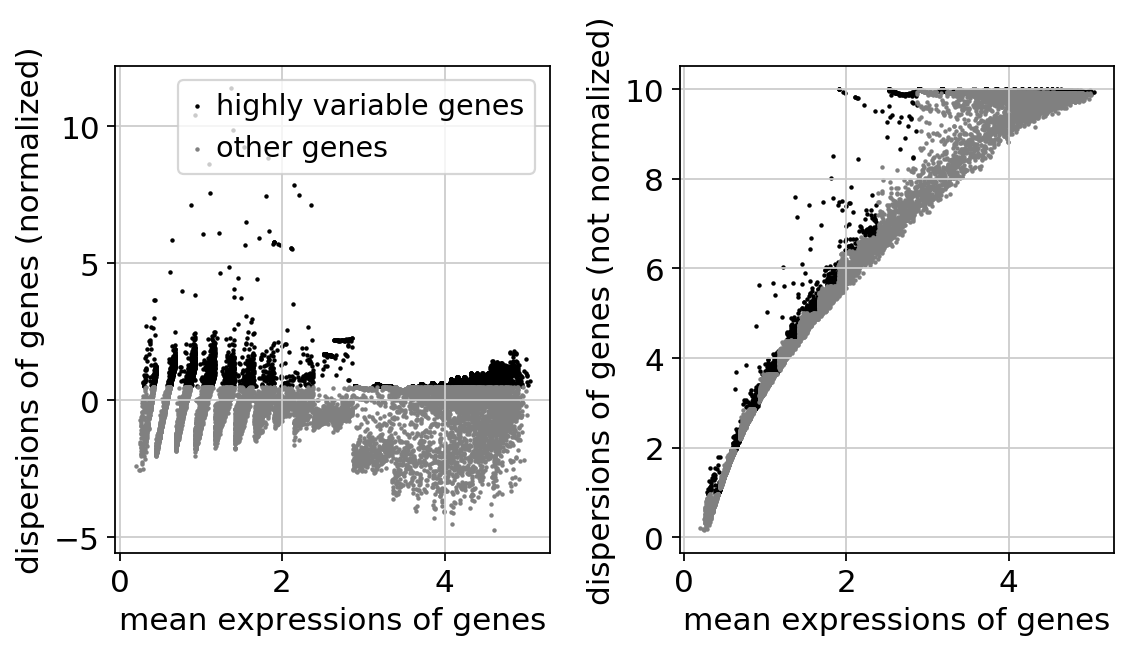

In [32]:
sc.pl.highly_variable_genes(adata)

## Dimensionality Reduction

Principal Component Analysis (PCA) reduces the dimensionality of the data by creating new variables(Principal components) that are linear combinations of the orginal variables which contain most of the variance in our dataset.

In [33]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:03)


Scatter plot showing our first two principal components.

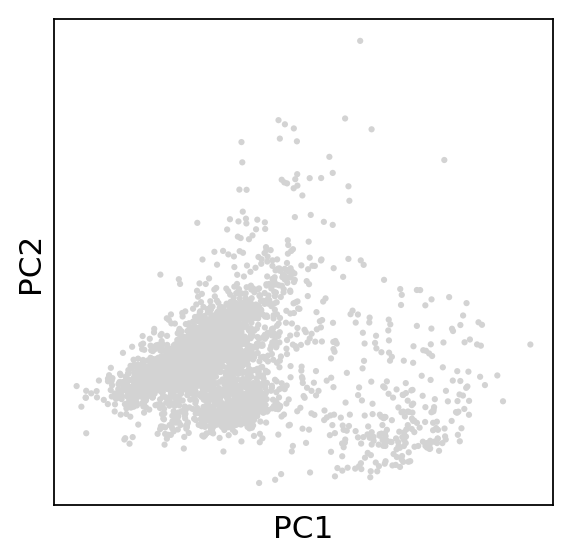

In [34]:
sc.pl.pca(adata)

Here the Principal Components are ranked according to the variance they represent in the data set. Each further principal component has a decreased explanation of the varaince it accounts for and this ranking gives information about how many PCs that should be considered in order to compute the neighborhood relations of cells in methods such as louvain clustering or tSNE visualization.

The number of PCs used is usually chosen when you have obtained enough PCs to explain the majority of the variance in your data and each additional PC does not contribute much.

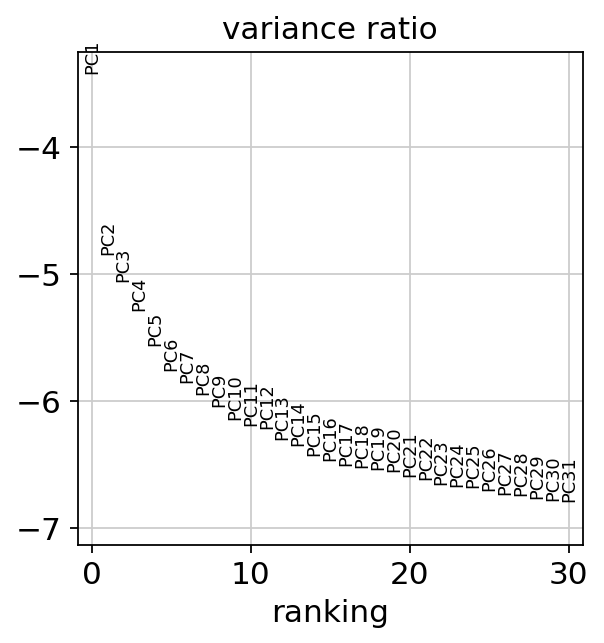

In [35]:
sc.pl.pca_variance_ratio(adata, log=True)

Compute the neighborhood graph of cells using the PCA representation.

In [36]:
sc.pp.neighbors(adata, n_neighbors=10)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)


In [37]:
sc.tl.umap(adata)
sc.tl.tsne(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:41)


## Data Correction

Check for batch effects of mouse_id, mouse_sex and plate through t-SNE projection.

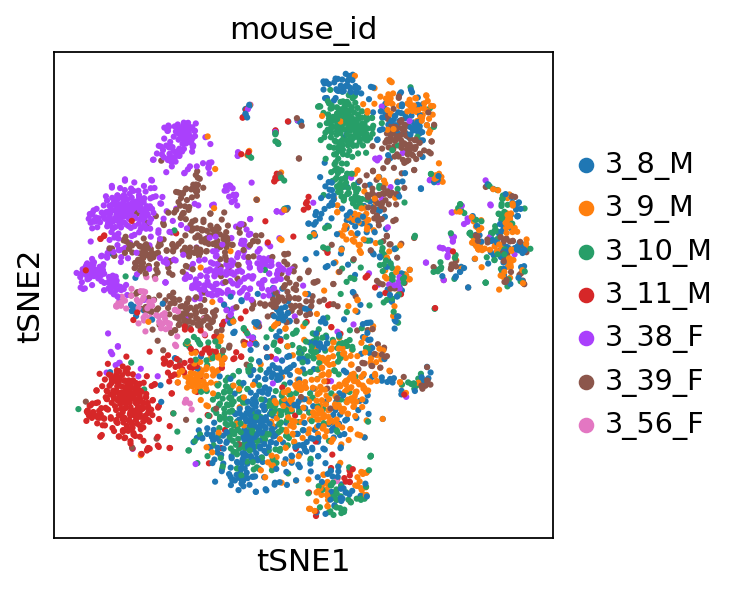

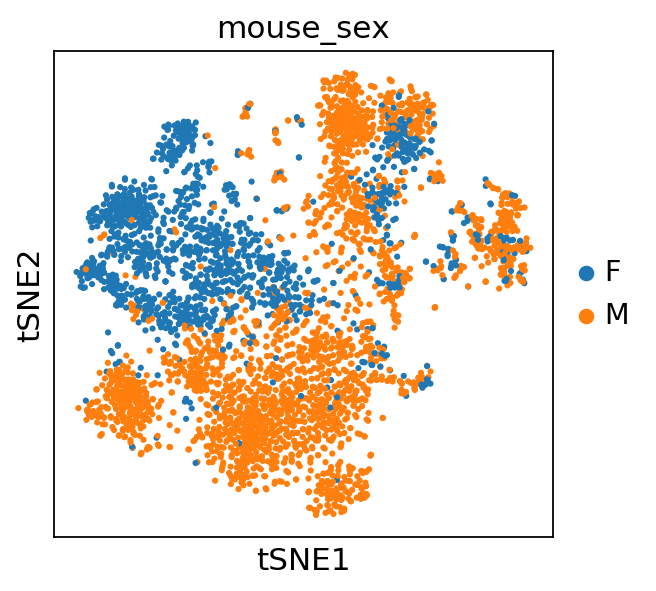

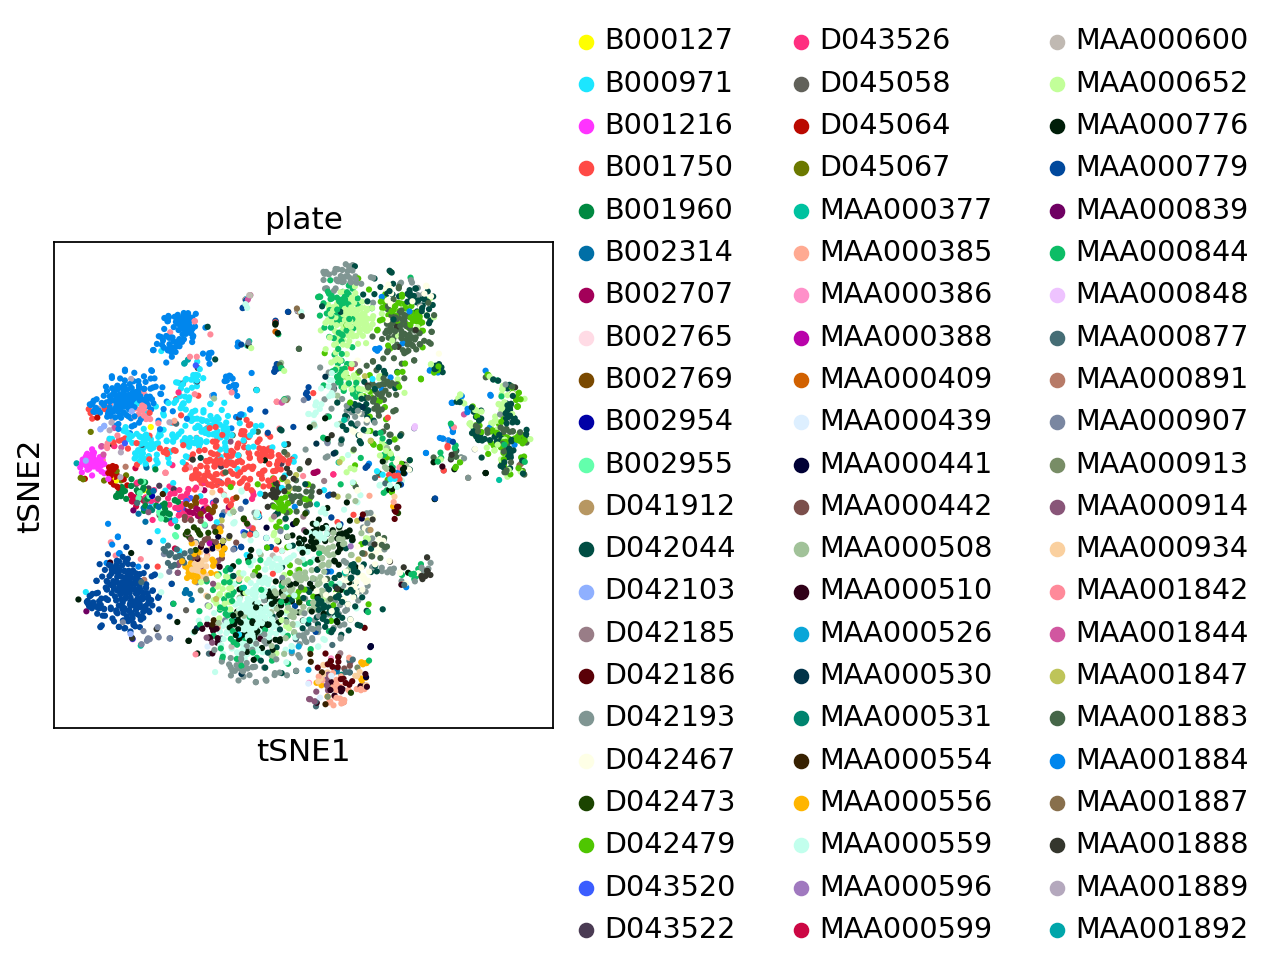

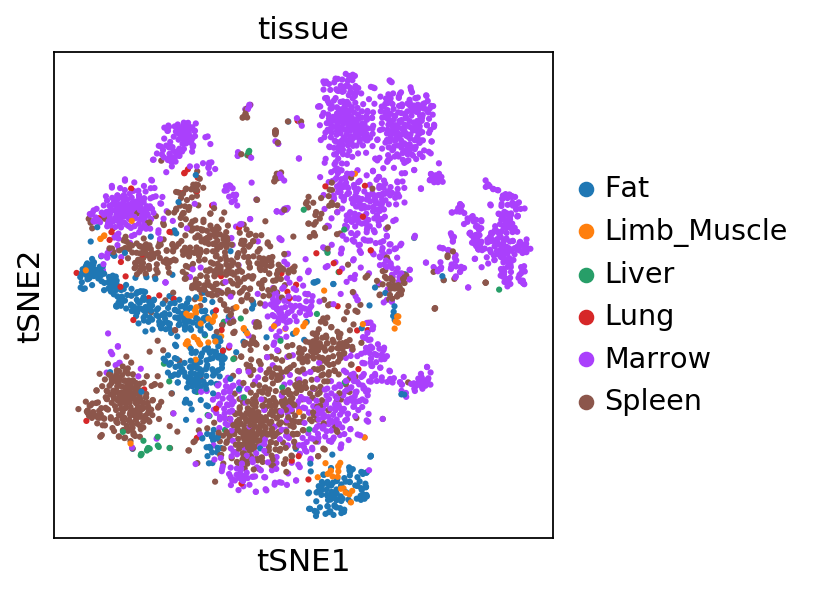

In [38]:
sc.pl.tsne(adata,color='mouse_id')
sc.pl.tsne(adata,color='mouse_sex')
sc.pl.tsne(adata,color='plate')
sc.pl.tsne(adata,color='tissue')

Batch correct cells using bbknn.

In [39]:
bk.bbknn(adata, batch_key='mouse_id')
bk.bbknn(adata, batch_key='mouse_sex')
#bk.bbknn(adata, batch_key='plate')
bk.bbknn(adata, batch_key='tissue')

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:02)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:00)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:00)


Post batch correction projection of cells using t-SNE.

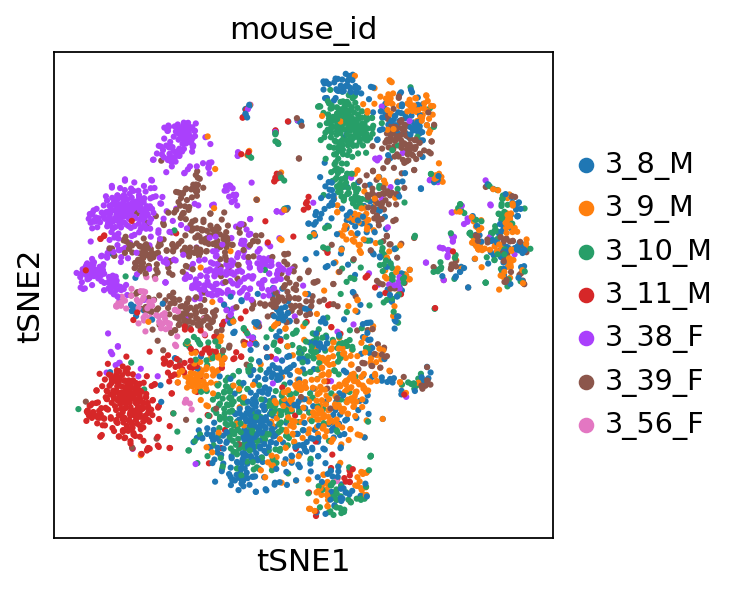

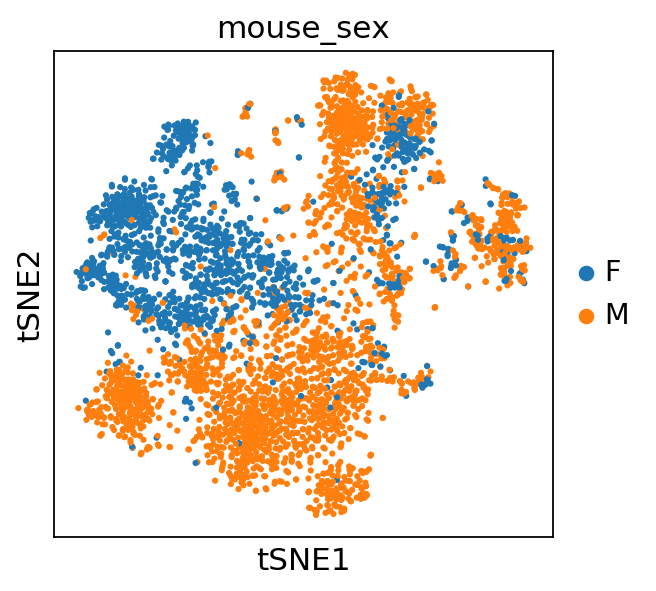

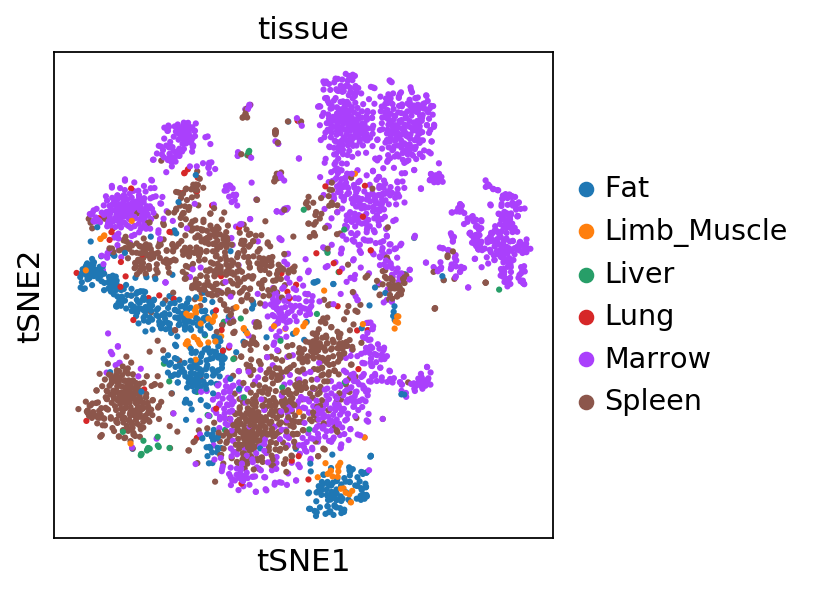

In [40]:
sc.pl.tsne(adata,color='mouse_id')
sc.pl.tsne(adata,color='mouse_sex')
sc.pl.tsne(adata,color='tissue')

## Cell Clustering

Clustering cells using Louvain algorithm.

In [41]:
sc.tl.louvain(adata,resolution=0.8)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


Projection of clustered cells in UMAP and t-SNE labeled by cluster and reference annotation.

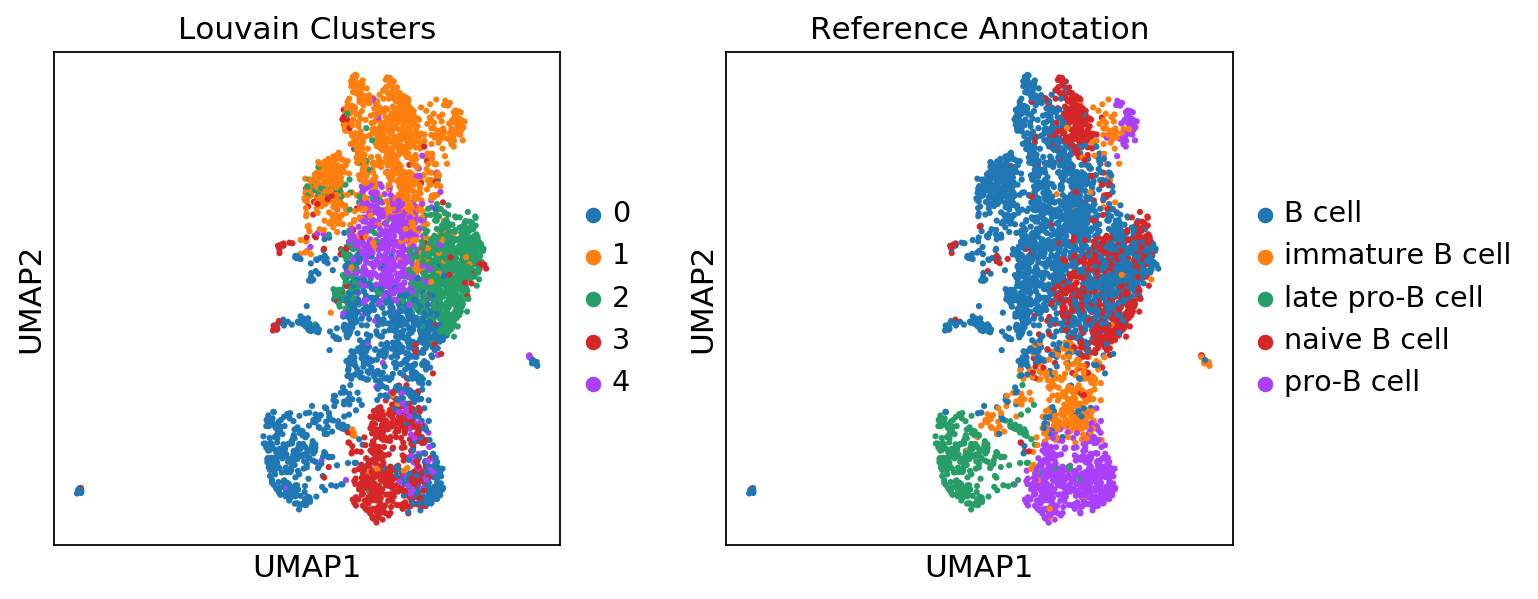

In [42]:
sc.pl.umap(adata, color=['louvain','ref_annotation'], title=['Louvain Clusters', 'Reference Annotation'])

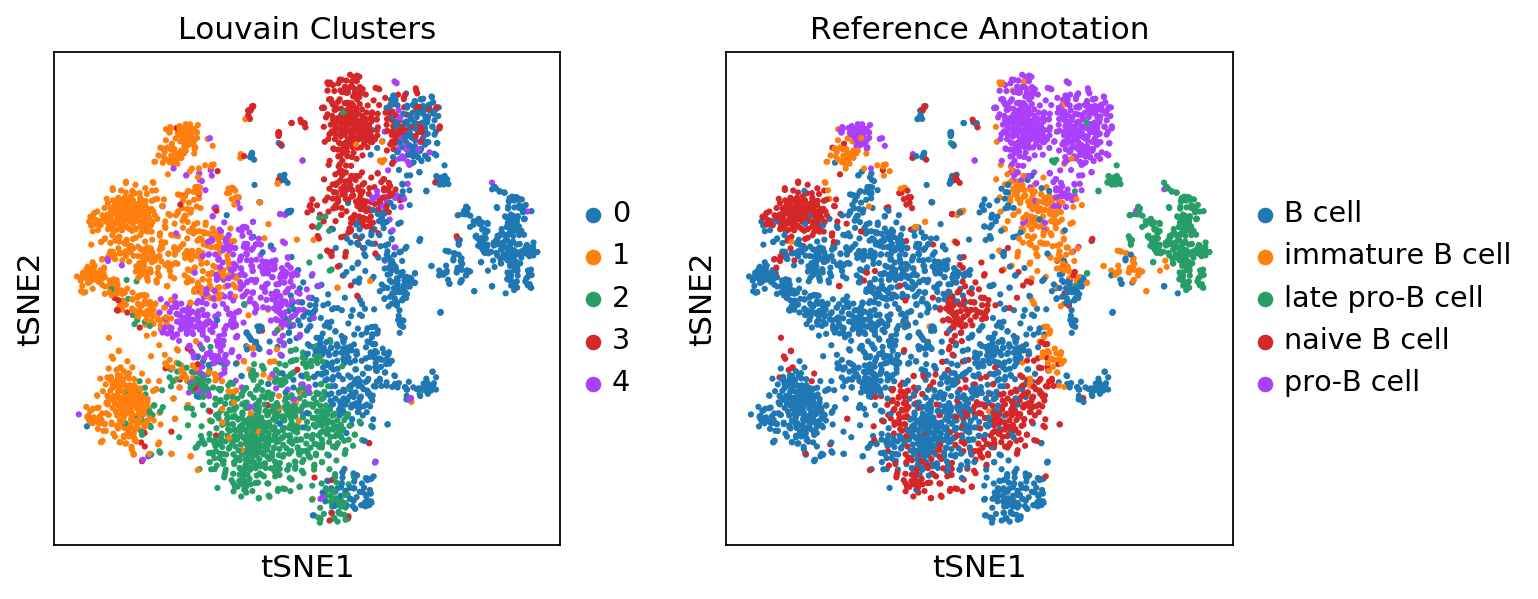

In [43]:
sc.pl.tsne(adata, color=['louvain','ref_annotation'], title=['Louvain Clusters', 'Reference Annotation'])

Compute a ranking for the highly expressed genes in each cluster using Wilcoxon rank-sum.

In [44]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon', use_raw=False)

ranking genes


/usr/local/lib/python3.6/dist-packages/scanpy/tools/_rank_genes_groups.py:388: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:11)


In [0]:
adata.write(results_file)

# Trajectory inference

## PAGA

PAGA trajectory inference by reference annotation.

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


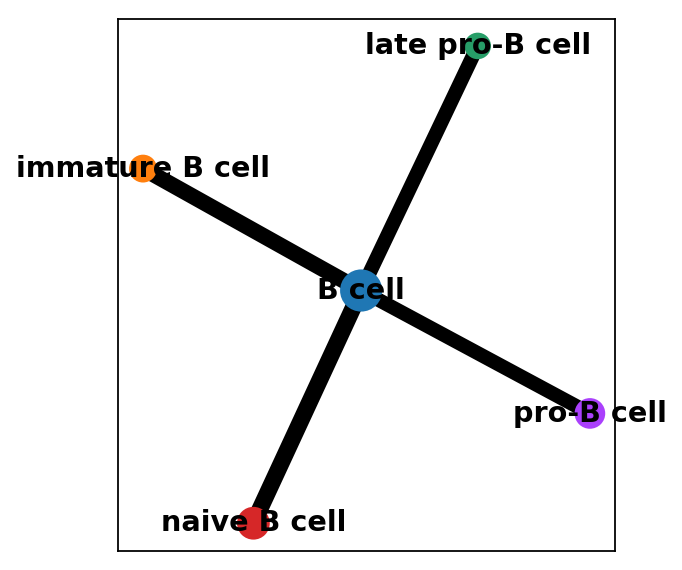

In [46]:
sc.tl.paga(adata, groups='ref_annotation')
sc.pl.paga(adata, threshold=0.1, color='ref_annotation')

In [0]:
adata.write(results_file)

In [0]:
adata_ti = adata.copy()

UMAP projection of PAGA calculated pseudo-time of B cells labeled by reference annotation.

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


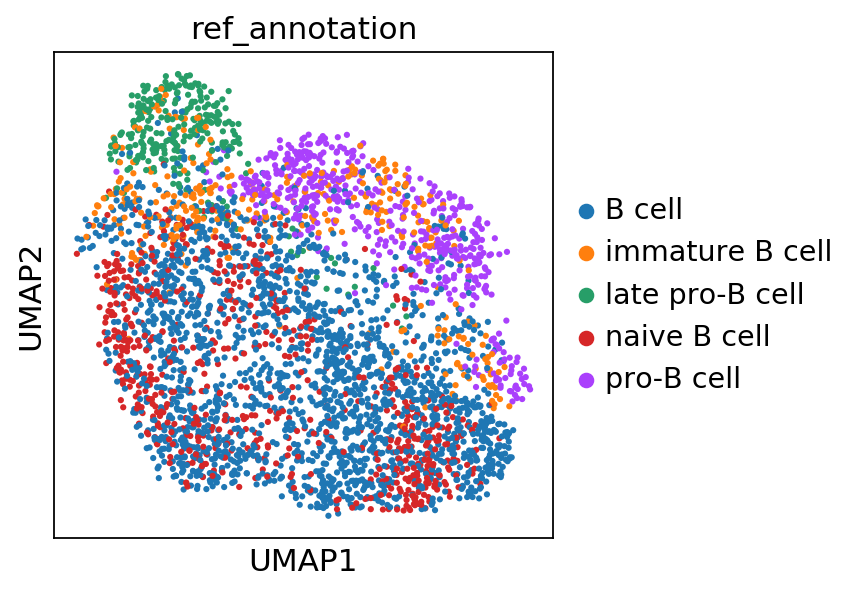

In [49]:
sc.tl.umap(adata_ti, init_pos=sc.tl._utils.get_init_pos_from_paga(adata))
sc.pl.umap(adata_ti, color='ref_annotation')

## Slingshot

Calculate the pseudo-time of the cell clusters (by reference annotation) using Slingshot. We stated two conditions, one with the starting cell stage and one with both starting and ending cell stage. For each of the conditions we use two dimensionality reduction methods, UMAP and PCA. 

[1] "1:"


R[write to console]: Using full covariance matrix

R[write to console]: Using full covariance matrix



[1] "adata_start_pca"
class: SlingshotDataSet 

 Samples Dimensions
    3842         50

lineages: 2 
Lineage1: pro-B cell  immature B cell  B cell  naive B cell  
Lineage2: pro-B cell  late pro-B cell  

curves: 2 
Curve1: Length: 60.909	Samples: 3541.78
Curve2: Length: 99.411	Samples: 899.01
[1] "adata_start_umap"
class: SlingshotDataSet 

 Samples Dimensions
    3842          2

lineages: 2 
Lineage1: pro-B cell  immature B cell  naive B cell  B cell  
Lineage2: pro-B cell  immature B cell  late pro-B cell  

curves: 2 
Curve1: Length: 33.796	Samples: 3291.81
Curve2: Length: 23.769	Samples: 1621.33
[1] ""
[1] "2:"


R[write to console]: Using full covariance matrix

R[write to console]: Using full covariance matrix



[1] "adata_startend_pca"
class: SlingshotDataSet 

 Samples Dimensions
    3842         50

lineages: 2 
Lineage1: pro-B cell  immature B cell  naive B cell  B cell  
Lineage2: pro-B cell  late pro-B cell  

curves: 2 
Curve1: Length: 104.53	Samples: 3533.55
Curve2: Length: 96.995	Samples: 836.74
[1] "adata_startend_umap"
class: SlingshotDataSet 

 Samples Dimensions
    3842          2

lineages: 2 
Lineage1: pro-B cell  immature B cell  naive B cell  B cell  
Lineage2: pro-B cell  immature B cell  late pro-B cell  

curves: 2 
Curve1: Length: 33.796	Samples: 3291.81
Curve2: Length: 23.769	Samples: 1621.33


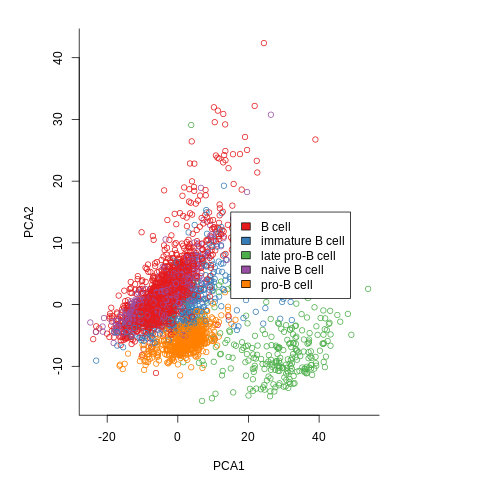

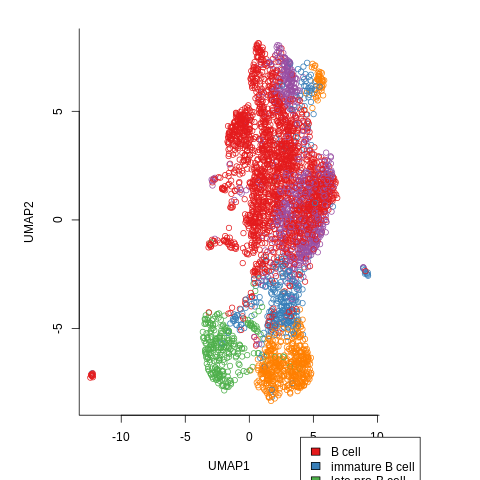

In [50]:
%%R -i adata

#Plot 1
colour_map = brewer.pal(9,'Set1')
par(xpd=TRUE)
par(mar=c(4.5,5.5,2,7))
plot(reducedDims(adata)$PCA[,1], reducedDims(adata)$PCA[,2], col=colour_map[colData(adata)$ref_annotation], bty='L', xlab='PCA1', ylab='PCA2')
legend(x=15, y=15, legend=unique(colData(adata)$ref_annotation), fill=colour_map[as.integer(unique(colData(adata)$ref_annotation))])
plot(reducedDims(adata)$UMAP[,1], reducedDims(adata)$UMAP[,2], col=colour_map[colData(adata)$ref_annotation], bty='L', xlab='UMAP1', ylab='UMAP2')
legend(x=4, y=-10, legend=unique(colData(adata)$ref_annotation), fill=colour_map[as.integer(unique(colData(adata)$ref_annotation))])

print("1:")
adata_start_pca <- slingshot(adata, clusterLabels = 'ref_annotation', reducedDim = 'PCA', start.clus='pro-B cell')
adata_start_umap <- slingshot(adata, clusterLabels = 'ref_annotation', reducedDim = 'UMAP', start.clus='pro-B cell')
print ("adata_start_pca")
print(SlingshotDataSet(adata_start_pca))
print("adata_start_umap")
print(SlingshotDataSet(adata_start_umap))

print("")
print("2:")
adata_startend_pca <- slingshot(adata, clusterLabels = 'ref_annotation', reducedDim = 'PCA', start.clus='pro-B cell', end.clus='B cell')
adata_startend_umap <- slingshot(adata, clusterLabels = 'ref_annotation', reducedDim = 'UMAP', start.clus='pro-B cell', end.clus='B cell')
print("adata_startend_pca")
print(SlingshotDataSet(adata_startend_pca))
print("adata_startend_umap")
print(SlingshotDataSet(adata_startend_umap))

Visualization of the best lineages by PCA and UMAP projection.

[1] "Lineage 1"
[1] "Lineages with clusters visualized"


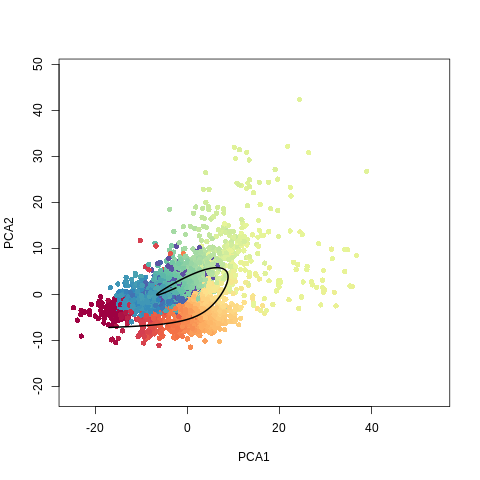

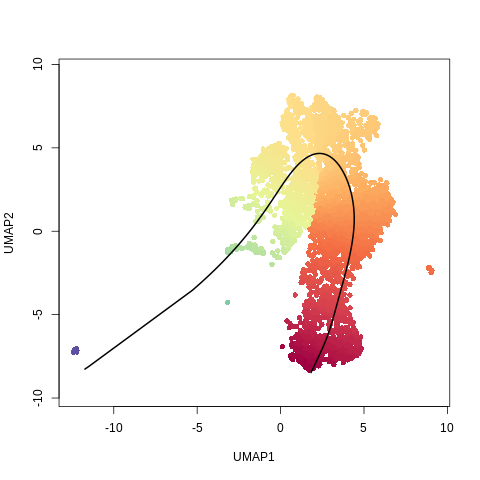

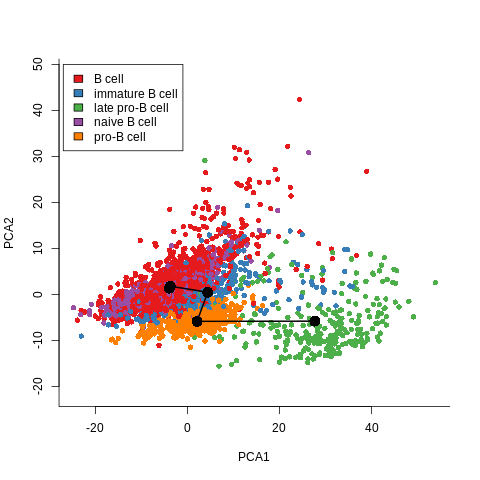

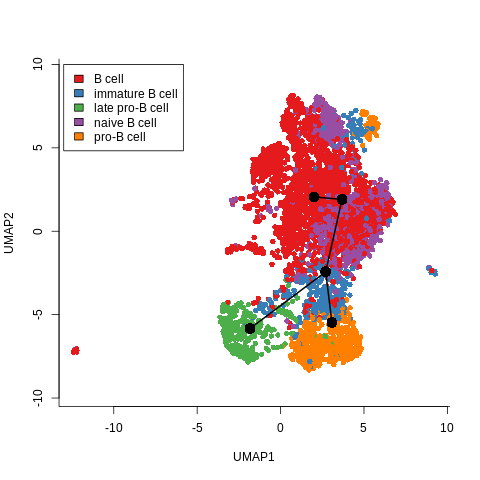

In [55]:
%%R

#Visualize sling_pseudo-time for adata_start

#Plot of lineage 1
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
print ("Lineage 1")
plot(reducedDims(adata_start_pca)$PCA[,c(1,2)], col = colors[cut(adata_start_pca$slingPseudotime_1,breaks=100)], pch=16, asp = 1, xlab='PCA1', ylab='PCA2')
lines(slingCurves(adata_start_pca)$curve1, lwd=2)
plot(reducedDims(adata_start_umap)$UMAP[,c(1,2)], col = colors[cut(adata_start_umap$slingPseudotime_1,breaks=100)], pch=16, asp = 1, xlab='UMAP1', ylab='UMAP2')
lines(slingCurves(adata_start_umap)$curve1, lwd=2)

#Plot of lineages with clusters visualized
print ("Lineages with clusters visualized")
par(xpd=TRUE)
plot(reducedDims(adata_start_pca)$PCA[,c(1,2)], col = brewer.pal(11,'Set1')[adata$ref_annotation], pch=16, asp = 1, bty='L', xlab='PCA1', ylab='PCA2')
lines(SlingshotDataSet(adata_start_pca), lwd=2, type='lineages')
legend(x=-27, y=50, legend=unique(colData(adata)$ref_annotation), fill=brewer.pal(11,'Set1')[as.integer(unique(colData(adata)$ref_annotation))])

plot(reducedDims(adata_start_umap)$UMAP[,c(1,2)], col = brewer.pal(11,'Set1')[adata$ref_annotation], pch=16, asp = 1, bty='L', xlab='UMAP1', ylab='UMAP2')
lines(SlingshotDataSet(adata_start_umap), lwd=2, type='lineages')
legend(x=-13, y=10, legend=unique(colData(adata)$ref_annotation), fill=brewer.pal(11,'Set1')[as.integer(unique(colData(adata)$ref_annotation))])

[1] "Lineage 1"
[1] "Lineages with clusters visualized"


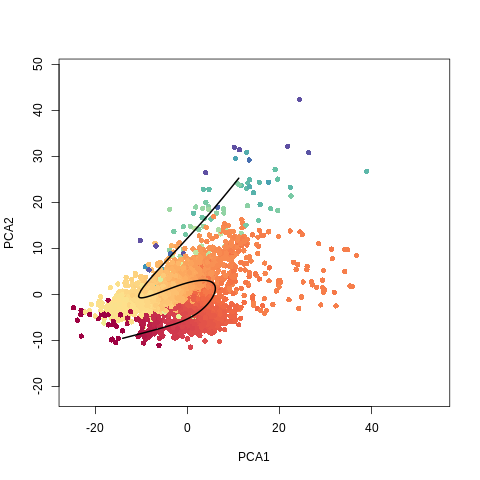

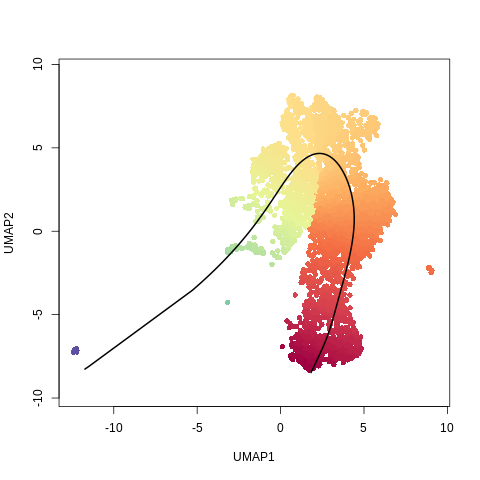

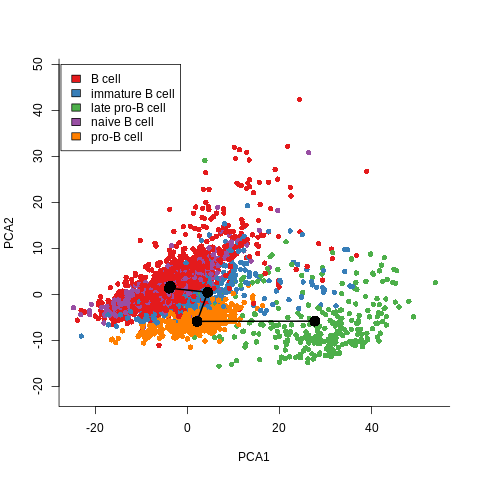

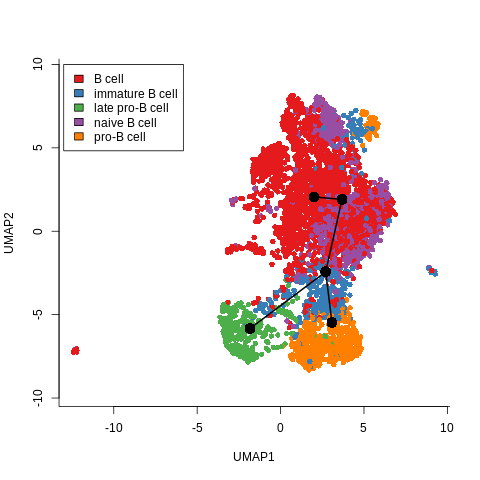

In [57]:
%%R

#Visualize sling_pseudo-time for adata_startend
#Plot of lineage 1
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
print ("Lineage 1")
plot(reducedDims(adata_startend_pca)$PCA[,c(1,2)], col = colors[cut(adata_startend_pca$slingPseudotime_1,breaks=100)], pch=16, asp = 1, xlab='PCA1', ylab='PCA2')
lines(slingCurves(adata_startend_pca)$curve1, lwd=2)
plot(reducedDims(adata_startend_umap)$UMAP[,c(1,2)], col = colors[cut(adata_startend_umap$slingPseudotime_1,breaks=100)], pch=16, asp = 1, xlab='UMAP1', ylab='UMAP2')
lines(slingCurves(adata_startend_umap)$curve1, lwd=2)

#Plot of lineages with clusters visualized
print ("Lineages with clusters visualized")
par(xpd=TRUE)
plot(reducedDims(adata_startend_pca)$PCA[,c(1,2)], col = brewer.pal(11,'Set1')[adata$ref_annotation], pch=16, asp = 1, bty='L', xlab='PCA1', ylab='PCA2')
lines(SlingshotDataSet(adata_startend_pca), lwd=2, type='lineages')
legend(x=-27.5, y=50, legend=unique(colData(adata)$ref_annotation), fill=brewer.pal(11,'Set1')[as.integer(unique(colData(adata)$ref_annotation))])

plot(reducedDims(adata_startend_umap)$UMAP[,c(1,2)], col = brewer.pal(11,'Set1')[adata$ref_annotation], pch=16, asp = 1, bty='L', xlab='UMAP1', ylab='UMAP2')
lines(SlingshotDataSet(adata_startend_umap), lwd=2, type='lineages')
legend(x=-13, y=10, legend=unique(colData(adata)$ref_annotation), fill=brewer.pal(11,'Set1')[as.integer(unique(colData(adata)$ref_annotation))])


## Loom file

In [53]:
def dfToNamedMatrix(df):
    arr_ip = [tuple(i) for i in df.as_matrix()]
    dtyp = np.dtype(list(zip(df.dtypes.index, df.dtypes)))
    arr = np.array(arr_ip, dtype=dtyp)
    return arr

ClusterMarkers_0 = pd.DataFrame(
    index=adata.raw.var.index,
    columns=[str(x) for x in range(max(set([int(x) for x in adata.obs['louvain']])) + 1)]
)

ClusterMarkers_0_avg_logFC = pd.DataFrame(
    index=adata.raw.var.index,
    columns=[str(x) for x in range(max(set([int(x) for x in adata.obs['louvain']])) + 1)]
)

ClusterMarkers_0_pval = pd.DataFrame(
    index=adata.raw.var.index,
    columns=[str(x) for x in range(max(set([int(x) for x in adata.obs['louvain']])) + 1)]
)

ClusterMarkers_0.fillna(0, inplace=True)
ClusterMarkers_0_avg_logFC.fillna(0, inplace=True)
ClusterMarkers_0_pval.fillna(0, inplace=True)

for i in range(max(set([int(x) for x in adata.obs['louvain']])) + 1):
    i = str(i)
    tot_genes = len(adata.uns['rank_genes_groups']['pvals_adj'][i])
    sigGenes = adata.uns['rank_genes_groups']['pvals_adj'][i] < 0.05
    deGenes = np.logical_and(np.logical_or(adata.uns['rank_genes_groups']['logfoldchanges'][i] >= 1.5,
                                           adata.uns['rank_genes_groups']['logfoldchanges'][i] <= -1.5),
                             np.isfinite(adata.uns['rank_genes_groups']['logfoldchanges'][i]))
    sigAndDE = np.logical_and(sigGenes, deGenes)
    names = adata.uns['rank_genes_groups']['names'][i][sigAndDE]
    ClusterMarkers_0.loc[names, i] = 1
    ClusterMarkers_0_avg_logFC.loc[names, i] = np.around(adata.uns['rank_genes_groups']['logfoldchanges'][i][sigAndDE],
                                                         decimals=6)
    ClusterMarkers_0_pval.loc[names, i] = np.around(adata.uns['rank_genes_groups']['pvals_adj'][i][sigAndDE],
                                                    decimals=6)

metaJson = {}
metaJson["metrics"] = []
metaJson["annotations"] = []

main_dr = pd.DataFrame(adata.obsm['X_umap'], columns=['_X', '_Y'])

metaJson['embeddings'] = [
    {
        "id": -1,
        "name": "HVG UMAP"
    }
]

Embeddings_X = pd.DataFrame()
Embeddings_Y = pd.DataFrame()

embeddings_id = 1

if 'X_tsne' in adata.obsm.keys():
    Embeddings_X[str(embeddings_id)] = pd.DataFrame(adata.obsm['X_tsne'])[0]
    Embeddings_Y[str(embeddings_id)] = pd.DataFrame(adata.obsm['X_tsne'])[1]
    metaJson['embeddings'].append(
        {
            "id": embeddings_id,
            "name": "HVG t-SNE"
        }
    )
    embeddings_id += 1

Embeddings_X[str(embeddings_id)] = pd.DataFrame(adata.obsm['X_pca'])[0]
Embeddings_Y[str(embeddings_id)] = pd.DataFrame(adata.obsm['X_pca'])[1]
metaJson['embeddings'].append(
    {
        "id": embeddings_id,
        "name": "HVG PC1/PC2"
    }
)

metaJson["clusterings"] = [
    {
        "id": 0,
        "group": "Louvain",
        "name": "Louvain default resolution",
        "clusters": [],
        "clusterMarkerMetrics": [
            {
                "accessor": "avg_logFC",
                "name": "Avg. logFC",
                "description": "Average log fold change from Wilcox test"
            }, {
                "accessor": "pval",
                "name": "Adjusted P-Value",
                "description": "Adjusted P-Value from Wilcox test"
            }
        ]
    }
]

for i in range(max(set([int(x) for x in adata.obs['louvain']])) + 1):
    clustDict = {}
    clustDict['id'] = i
    clustDict['description'] = f'Unannotated Cluster {i}'
    metaJson['clusterings'][0]['clusters'].append(clustDict)

clusterings = pd.DataFrame()

clusterings["0"] = adata.obs['louvain'].values.astype(np.int64)

col_attrs = {
    "CellID": np.array(adata.obs.index),
    "Embedding": dfToNamedMatrix(main_dr),
    "Embeddings_X": dfToNamedMatrix(Embeddings_X),
    "Embeddings_Y": dfToNamedMatrix(Embeddings_Y),
    "Clusterings": dfToNamedMatrix(clusterings),
    "ClusterID": np.array(adata.obs['louvain'].values)
}

for col in adata.obs.keys():
    if type(adata.obs[col].dtype) == pd.core.dtypes.dtypes.CategoricalDtype:
        metaJson["annotations"].append(
            {
                "name": col,
                "values": list(set(adata.obs[col].values))
            }
        )
    else:
        metaJson["metrics"].append(
            {
                "name": col
            }
        )
    col_attrs[col] = np.array(adata.obs[col].values)

row_attrs = {
    "Gene": np.array(adata.raw.var.index),
    "ClusterMarkers_0": dfToNamedMatrix(ClusterMarkers_0),
    "ClusterMarkers_0_avg_logFC": dfToNamedMatrix(ClusterMarkers_0_avg_logFC),
    "ClusterMarkers_0_pval": dfToNamedMatrix(ClusterMarkers_0_pval)
}

attrs = {"MetaData": json.dumps(metaJson)}

attrs['MetaData'] = base64.b64encode(zlib.compress(json.dumps(metaJson).encode('ascii'))).decode('ascii')

lp.create(
    filename="/content/drive/My Drive/IntegratedProject/Data/write/LoomFiles/Bcell.loom",
    layers=(adata.raw.X).T,
    row_attrs=row_attrs,
    col_attrs=col_attrs,
    file_attrs=attrs
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
